<a href="https://colab.research.google.com/github/ateyodin/Stock/blob/master/stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing NumPy, Pandas, Matplotlib, Scikit-learn and Keras/Tensorflow
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber
from keras.optimizers import SGD

Using TensorFlow backend.


In [2]:
# Download the data and store it
# Apple Stock 
!wget -O Apple.csv https://www.dropbox.com/s/2zy6dp2sersn4bq/AAPL.csv?dl=0

--2019-09-03 00:49:28--  https://www.dropbox.com/s/2zy6dp2sersn4bq/AAPL.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/2zy6dp2sersn4bq/AAPL.csv [following]
--2019-09-03 00:49:28--  https://www.dropbox.com/s/raw/2zy6dp2sersn4bq/AAPL.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdd1e1b34d4ade6254586f7c32c.dl.dropboxusercontent.com/cd/0/inline/An0bGuxk8cp0rqHfLbx9Qe6UFGjKKls9ScjlgMorqJJXvA_9BHCAZkBMPPEq5T26AU8Uy2BN9WxufESaJRWPAceCu_nVYetTZ5r-g-sk7xXhc62gEwx795DO3wwGfWVq07I/file# [following]
--2019-09-03 00:49:28--  https://ucdd1e1b34d4ade6254586f7c32c.dl.dropboxusercontent.com/cd/0/inline/An0bGuxk8cp0rqHfLbx9Qe6UFGjKKls9ScjlgMorqJJXvA_9BHCAZkBMPPEq5T26AU8Uy2BN9WxufESaJRWPAceCu_nVYetTZ5r-g-sk7xXhc62gEwx795DO3

In [0]:
df = pd.read_csv('Apple.csv')

In [4]:
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-09-04,228.410004,229.179993,226.630005,228.360001,224.870499,27390100
2018-09-05,228.990005,229.669998,225.100006,226.869995,223.403275,33333000
2018-09-06,226.229996,227.350006,221.300003,223.100006,219.690903,34290000
2018-09-07,221.850006,225.369995,220.710007,221.300003,217.918411,37619800
2018-09-10,220.949997,221.850006,216.470001,218.330002,214.993759,39516500


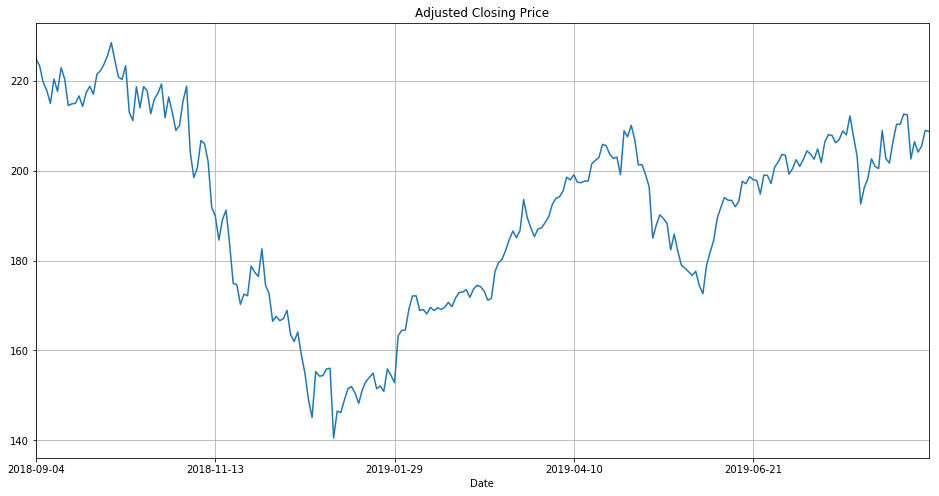

In [5]:
df['Adj Close'].plot(label='Apple', figsize=(16,8), title='Adjusted Closing Price', grid=True)

In [0]:
window_size = 32 # Allow us to look at 32 days into the past
# Prepare the data so that we have 32 day windows and predict what the next day should be

# Get indices of access for the data
num_samples = len(df) - window_size
indices = np.arange(num_samples).astype(np.int)[:,None] + np.arange(window_size + 1).astype(np.int)

In [0]:
data = df['Adj Close'].values[indices] # Create the 2D matrix of training samples

In [0]:
X = data[:,:-1] # Each row represents 32 days in the past
y = data[:,-1] # Each output value represents the 33rd day

In [0]:
# Train and test split
split_fraction = 0.8
ind_split = int(split_fraction * num_samples)
X_train = X[:ind_split]
y_train = y[:ind_split]
X_test = X[ind_split:]
y_test = y[ind_split:]

In [0]:
# Train
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# Infer
y_pred_train_ridge = ridge_model.predict(X_train)
y_pred_ridge = ridge_model.predict(X_test)

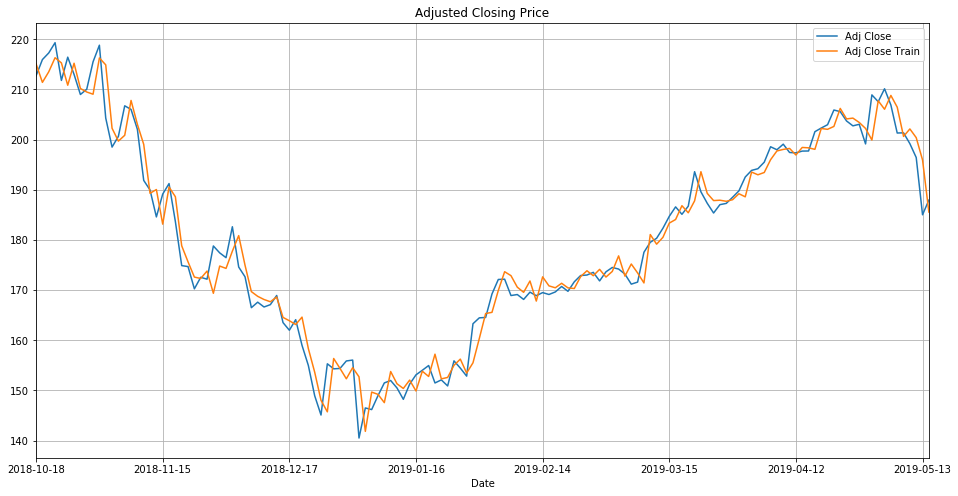

In [12]:
# Plot what it looks like for the training data
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_ridge['Adj Close Train'] = y_pred_train_ridge[:-window_size]
df_ridge.plot(label='Apple', figsize=(16,8), title='Adjusted Closing Price', grid=True)

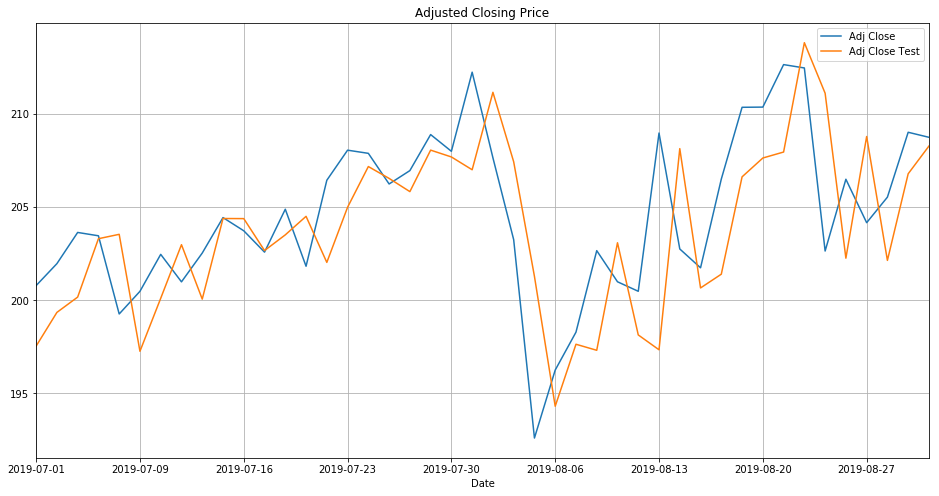

In [13]:
# Same for the test
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_ridge['Adj Close Test'] = y_pred_ridge
df_ridge.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

In [0]:
# Model #2 - Gradient Boosting Trees
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

# Infer
y_pred_train_gb = gb_model.predict(X_train)
y_pred_gb = gb_model.predict(X_test)

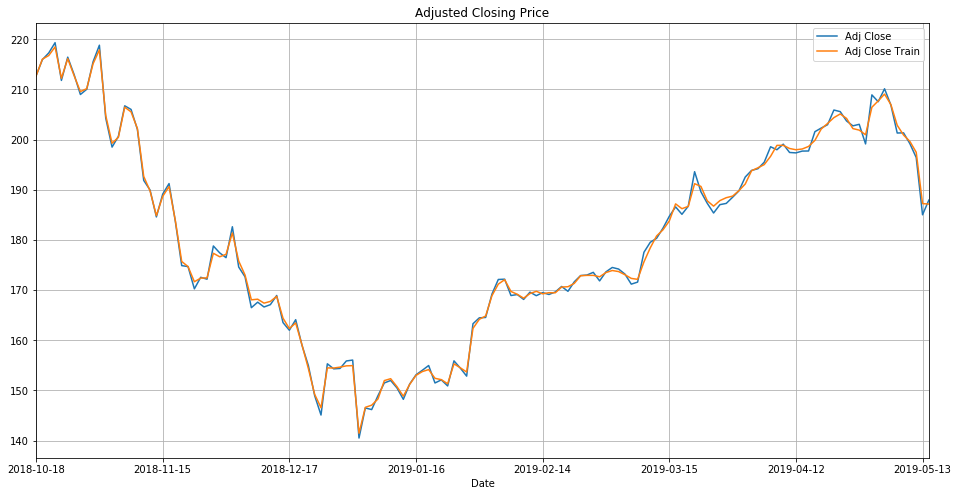

In [15]:
# Plot what it looks like for the training data
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_gb['Adj Close Train'] = y_pred_train_gb[:-window_size]
df_gb.plot(label='Apple', figsize=(16,8), title='Adjusted Closing Price', grid=True)

In [16]:
# Model #3 - Using RNNs
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])

keras_model.summary()

W0903 01:04:06.752452 140174207403904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0903 01:04:06.796741 140174207403904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0903 01:04:06.804682 140174207403904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 32, 128)           768       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 128)           82048     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32, 128)           131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [17]:
# First figure out the right learning rate
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = SGD(lr=1e-8, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
# Scale the data due to LSTM units
scaler = MinMaxScaler(feature_range=(-1, 1))
data_transform = scaler.fit_transform(df['Adj Close'].values[:,None])
data_transform = data_transform[indices]
X2 = data_transform[:,:-1]
y2 = data_transform[:,-1]
X_train_reshape = X2[:ind_split]
y_train_reshape = y2[:ind_split]
X_test_reshape = X2[ind_split:]
y_test_reshape = y2[ind_split:]

W0903 01:04:50.757103 140174207403904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [18]:
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, callbacks=[lr_schedule], validation_data=(X_test_reshape, y_test_reshape))

W0903 01:05:13.552608 140174207403904 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0903 01:05:14.944041 140174207403904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0903 01:05:15.007668 140174207403904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 174 samples, validate on 44 samples
Epoch 1/250
174/174 [==============================] - 3s 15ms/step - loss: 0.0770 - mean_absolute_error: 0.3315 - val_loss: 0.0904 - val_mean_absolute_error: 0.4142
Epoch 2/250
174/174 [==============================] - 0s 2ms/step - loss: 0.0770 - mean_absolute_error: 0.3315 - val_loss: 0.0904 - val_mean_absolute_error: 0.4142
Epoch 3/250
174/174 [==============================] - 0s 2ms/step - loss: 0.0770 - mean_absolute_error: 0.3315 - val_loss: 0.0904 - val_mean_absolute_error: 0.4142
Epoch 4/250
174/174 [==============================] - 0s 2ms/step - loss: 0.0770 - mean_absolute_error: 0.3315 - val_loss: 0.0904 - val_mean_absolute_error: 0.4142
Epoch 5/250
174/174 [==============================] - 0s 2ms/step - loss: 0.0770 - mean_absolute_error: 0.3315 - val_loss: 0.0904 - val_mean_absolute_error: 0.4142
Epoch 6/250
174/174 [==============================] - 0s 2ms/step - loss: 0.0770 - mean_absolute_error: 0.3315 - val_loss: 0.090

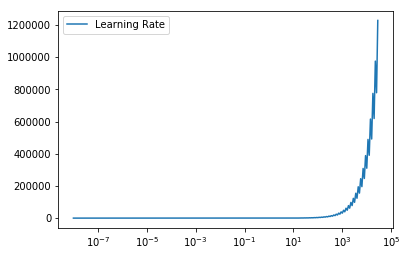

In [21]:
plt.semilogx(history.history['lr'], history.history['val_loss'])
plt.legend(['Learning Rate', 'Validation Loss'])

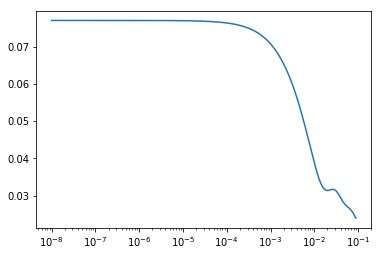

In [22]:
plt.semilogx(history.history['lr'][:140], history.history['loss'][:140])

In [23]:
# Observing the above graph, 0.1 seems to be the best learning rate
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])


optimizer = SGD(lr=0.1, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, validation_data=(X_test_reshape, y_test_reshape))

Train on 174 samples, validate on 44 samples
Epoch 1/250
174/174 [==============================] - 2s 13ms/step - loss: 0.1047 - mean_absolute_error: 0.3830 - val_loss: 0.1234 - val_mean_absolute_error: 0.4875
Epoch 2/250
174/174 [==============================] - 0s 2ms/step - loss: 0.0837 - mean_absolute_error: 0.3466 - val_loss: 0.1070 - val_mean_absolute_error: 0.4529
Epoch 3/250
174/174 [==============================] - 0s 2ms/step - loss: 0.0594 - mean_absolute_error: 0.2912 - val_loss: 0.0652 - val_mean_absolute_error: 0.3473
Epoch 4/250
174/174 [==============================] - 0s 2ms/step - loss: 0.0404 - mean_absolute_error: 0.2468 - val_loss: 0.0204 - val_mean_absolute_error: 0.1847
Epoch 5/250
174/174 [==============================] - 0s 2ms/step - loss: 0.0344 - mean_absolute_error: 0.2327 - val_loss: 0.0071 - val_mean_absolute_error: 0.0926
Epoch 6/250
174/174 [==============================] - 0s 2ms/step - loss: 0.0443 - mean_absolute_error: 0.2554 - val_loss: 0.007

In [0]:
y_pred_train_keras = scaler.inverse_transform(keras_model.predict(X_train_reshape, batch_size=256))
y_pred_keras = scaler.inverse_transform(keras_model.predict(X_test_reshape, batch_size=256))

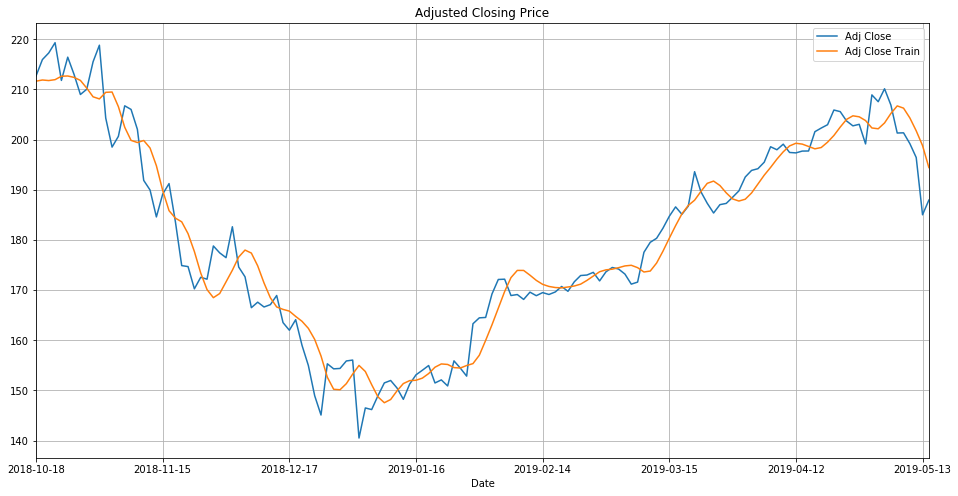

In [25]:
# Plot what it looks like for the training data
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_keras['Adj Close Train'] = y_pred_train_keras[:-window_size]
df_keras.plot(label='Apple', figsize=(16,8), title='Adjusted Closing Price', grid=True)

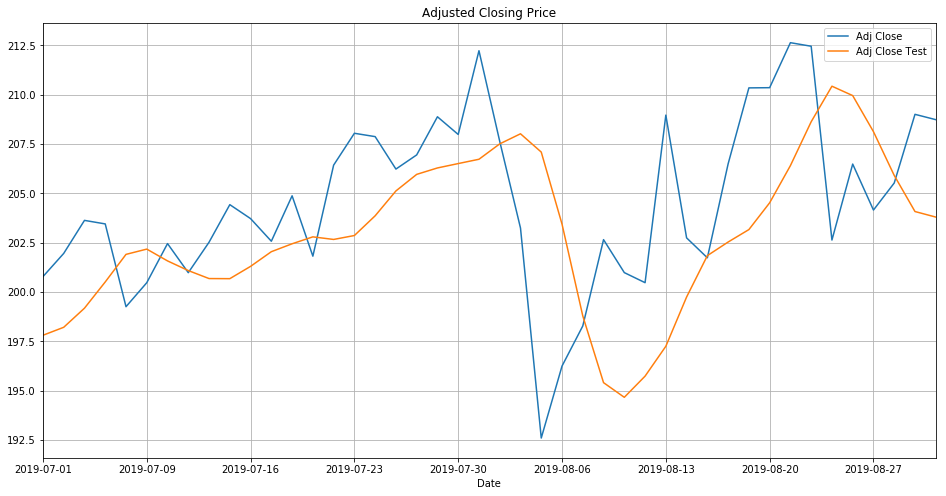

In [26]:
# Same for the test
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_keras['Adj Close Test'] = y_pred_keras
df_keras.plot(label='Apple', figsize=(16,8), title='Adjusted Closing Price', grid=True)

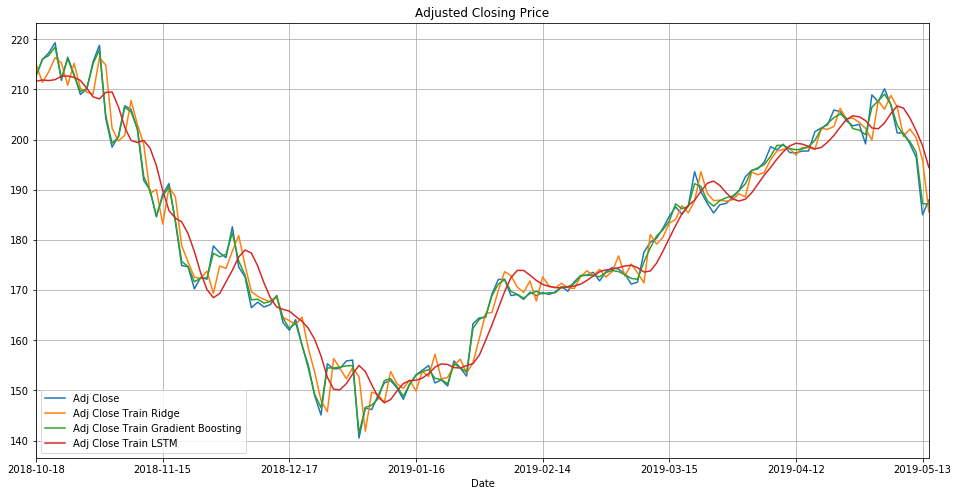

In [27]:
df_train = df.copy()
df_train.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_train = df_train.iloc[window_size:ind_split] # Past 32 days we don't know yet
# Add in all of our methods
df_train['Adj Close Train Ridge'] = y_pred_train_ridge[:-window_size]
df_train['Adj Close Train Gradient Boosting'] = y_pred_train_gb[:-window_size]
df_train['Adj Close Train LSTM'] = y_pred_train_keras[:-window_size]
# Plot the data now
df_train.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

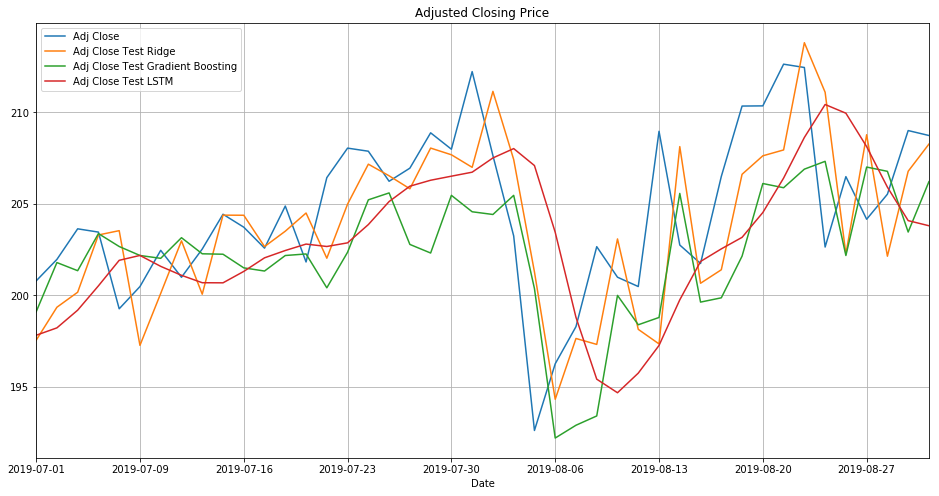

In [28]:
df_test = df.copy()
df_test.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_test = df_test.iloc[ind_split+window_size:] # Past 32 days we don't know yet
# Add in all of our methods
df_test['Adj Close Test Ridge'] = y_pred_ridge
df_test['Adj Close Test Gradient Boosting'] = y_pred_gb
df_test['Adj Close Test LSTM'] = y_pred_keras
# Plot the data now
df_test.plot(label='Apple', figsize=(16,8), title='Adjusted Closing Price', grid=True)

In [0]:
num_days = 10 # Let's try and forecase the next 10 days or two years

# Get the last window_size (32) days
data_seed = df['Adj Close'].values[-window_size:][None]
# Get the normalized data as well for the neural network
data_seed_norm = scaler.transform(data_seed)
input_values = {"ridge": data_seed, "gb": data_seed, "keras": data_seed_norm.copy()}
values = {"ridge": [], "gb": [], "keras": []}
for i in range(num_days): # For each day...
    # Predict the next price given the previous N prices
    values["ridge"].append(ridge_model.predict(input_values["ridge"])[0])
    values["gb"].append(gb_model.predict(input_values["gb"])[0])
    values["keras"].append(keras_model.predict(input_values["keras"][...,None])[0][0])

    # Dump the oldest price and put the newest price at the end
    for v in input_values:
        val = input_values[v]
        val = np.insert(val, -1, values[v][-1], axis=1)
        val = np.delete(val, 0, axis=1)
        input_values[v] = val.copy()

# Convert all to NumPy arrays
for v in input_values:
    values[v] = np.array(values[v])

# Unnormalize prices from NN approach
values["keras"] = scaler.inverse_transform(values["keras"][None])[0]

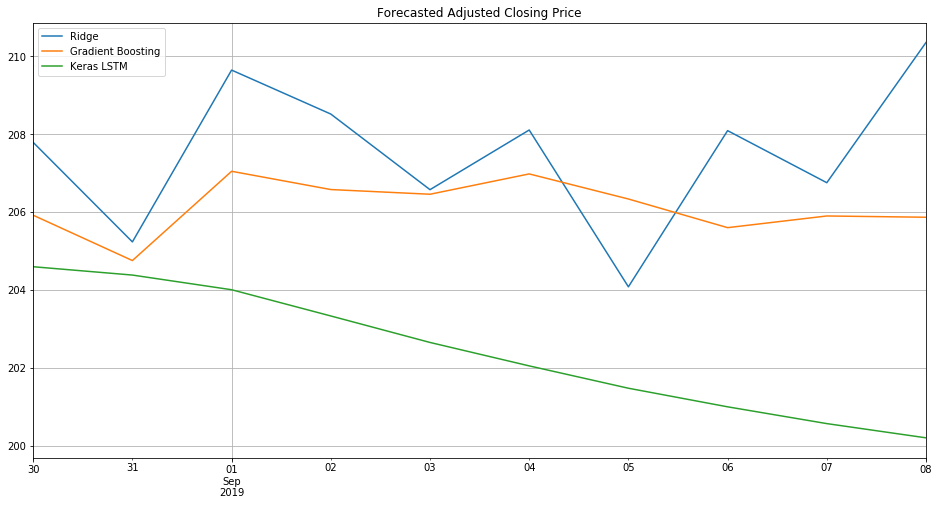

In [30]:
from datetime import timedelta, datetime
last_date = datetime.strptime(df.index[-1], '%Y-%m-%d')
df_forecast = pd.DataFrame()
df_forecast["Ridge"] = values["ridge"]
df_forecast["Gradient Boosting"] = values["gb"]
df_forecast["Keras LSTM"] = values["keras"]
df_forecast.index = pd.date_range(start=last_date, periods=num_days)
df_forecast.plot(label='TSLA', figsize=(16,8), title='Forecasted Adjusted Closing Price', grid=True)